## Training for CBOW Word Embeddings
In this notebook we would like to employ the CBOW algorithm to output pretrained word embeddings, which will be used to perform text classification. The text classification will be performed on real-time tweets obtained from the Twitter Public Streaming API. Once we have classified the tweet, we can then further process them and index (store) in an Elasticsearch index (data storage). The Elasticsearch index will serve as a real-time, fast search engine, which will allows us to perform different kinds of analyses and visualizations on the classified and preprocessed tweets using Kibana.

### Importing Libraries
The first thing is to import the libraries.

In [1]:
import helpers.pickle_helpers as ph
import pandas as pd
import re
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

### checking PyTorch version
print(torch.__version__)

0.4.1


### Data Loading
The data has been preprocessed, cleaned, and formated as a pandas dataframe. Below you can see the code used for importing the dataframes. Dataframes allow us to perform basic statistics and transformations to our dataset. Although it is not mandatory to have our data in such format, I strongly recommend it for in case you like to perform some extra analysis on your dataset.

In [2]:
### load the traing and test dataframes
train_data = ph.load_from_pickle(directory="data/datasets/df_grained_tweet_tr.pkl")
test_data = ph.load_from_pickle(directory="data/datasets/df_grained_tweet_te_unbal.pkl")

###  renaming the column names of the dataframe
train_data.rename(index=str, columns={"emo":"emotions", "sentence": "text"}, inplace=True);
test_data.rename(index=str, columns={"emo":"emotions", "sentence": "text"}, inplace=True);

### remove hashtags to avoid any bias from them
train_data.text = train_data.text.str.replace(" <hashtag>", "")
test_data.text = test_data.text.str.replace(" <hashtag>", "")

### Emotion Distribution
We can now explore the distribution of our dataset.

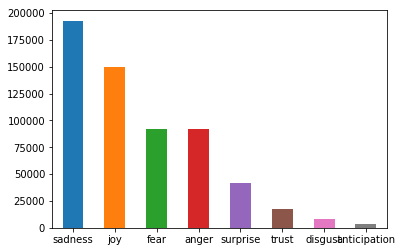

In [3]:
train_data.emotions.value_counts().plot(kind="bar", rot=0)

### Processing and Creating Vocabulary
Before training and constructing the word embeddings we need to process the data and create a vocabulary. The functions below achieve these two things.

In [4]:
def clearstring(string):
    """ clean tweets """
    string = re.sub('[^\'\"A-Za-z0-9 ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    string = [y for y in string if len(y) > 3 and y.find('nbsp') < 0]
    return ' '.join(string)

def read_data():
    """ generate vocabulary """
    vocab = []
    text = train_data.text.values.tolist()
    for t in text:
        strings = clearstring(t)
        vocab+=strings.split()
    return vocab

In [5]:
### build the vocabulary
vocabulary = read_data()
print("example 10 words:", vocabulary[:10])
print('size corpus:',len(vocabulary))
vocabulary_size = len(list(set(vocabulary)))
print('size of unique words:',vocabulary_size)

example 10 words: ['love', 'with', 'midi', 'skirt', 'woooo', 'usermention', 'holme', 'upon', 'spalding', 'moor']
size corpus: 3698224
size of unique words: 92095


In [6]:
### print the vocabulary
vocabulary[:10]

['love',
 'with',
 'midi',
 'skirt',
 'woooo',
 'usermention',
 'holme',
 'upon',
 'spalding',
 'moor']

### Build The Dataset
Now that we have the vocabulary, we would like to format our dataset into sequence of tokens represented by the index of those tokens in the vocabulary. Look at the code below to see how this can be achieved. In particular note the example of how to convert the data to sequence of indexed tokens. The reason the index is necessary is because this is needed by the model in order to identify words by their ids instead of their actual raw representation (i.e., letters).

In [7]:
def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # increase index as words added
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [8]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
del vocabulary

In [9]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:15], [reverse_dictionary[i] for i in data[:15]])

Most common words (+UNK) [['UNK', 1], ('usermention', 147536), ('this', 52001), ('just', 51505), ('that', 50171)]
Sample data [34, 5, 16555, 3984, 2340, 1, 30165, 2511, 30166, 24865, 1075, 1815, 161, 97, 117] ['love', 'with', 'midi', 'skirt', 'woooo', 'usermention', 'holme', 'upon', 'spalding', 'moor', 'rock', 'challenge', 'please', 'well', 'done']


In [10]:
len(data)

3698224

### Generating Batches
For training the CBOW model with the input sequences of tokens, we need to generate batches and feed those to the model. The batches will be of a particular size, in this case 8, and also context window, which determines the final size of the input sequence. For instance, if the context window size is 1, then we have a target and two context words, which means that the sequence size results in three tokens. See the code below for how to achieve this.

In [11]:
data_index = 0

def generate_batch(batch_size, context_window):
    # all context tokens should be used, hence no associated num_skips argument
    global data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    data_index-=1
    return batch, labels

In [12]:
batch, labels = generate_batch(batch_size=8, context_window=1)

In [13]:
[(reverse_dictionary[i],i) for i in data[:10]]

[('love', 34),
 ('with', 5),
 ('midi', 16555),
 ('skirt', 3984),
 ('woooo', 2340),
 ('usermention', 1),
 ('holme', 30165),
 ('upon', 2511),
 ('spalding', 30166),
 ('moor', 24865)]

In [14]:
data[:10]

[34, 5, 16555, 3984, 2340, 1, 30165, 2511, 30166, 24865]

In [16]:
### a batch sample
for i in range(8):
    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
          batch[i, 1], reverse_dictionary[batch[i, 1]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

34 love 16555 midi -> 5 with
5 with 3984 skirt -> 16555 midi
16555 midi 2340 woooo -> 3984 skirt
3984 skirt 1 usermention -> 2340 woooo
2340 woooo 30165 holme -> 1 usermention
1 usermention 2511 upon -> 30165 holme
30165 holme 30166 spalding -> 2511 upon
2511 upon 24865 moor -> 30166 spalding


### Model
Now that we have a function to generate batches of sequences, which we can feed to the mode, it's time to actually build the model. The model we will use here is a one layer feed forward neural network, which train with the goal to learn parameters that will represent the values of the word embeddings. See code below for the model we will use to train the embeddings. It is assumed that you are familiar with PyTorch to understand the code below. 

In [18]:
class EmoCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(EmoCBOW, self).__init__()
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, inputs):
        # batch_size X context X embedding_dim
        embeds = self.embeddings(inputs)
        average_embeds = torch.mean(embeds, dim=1)
        out = self.linear(average_embeds) 
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    def get_word_emdedding(self, word):
        word = Variable(torch.LongTensor([dictionary[word]]).cuda())
        return self.embeddings(word).view(1,-1)

### Pretesting Model
We would like to test the model with a sample batch before we do the actual training of the word embeddings. Below is sample code on how to achieve this. 

In [19]:
### test with one batch
context_batch, target_batch = generate_batch(batch_size=8, context_window=1)

context_var = Variable(torch.LongTensor(context_batch))
### print(context_var)
dummy_model = EmoCBOW(vocab_size=vocabulary_size, embedding_dim=10, context_size=1)
log_probs = dummy_model(context_var)
print(log_probs.size())

data_index = 0 # reset index

torch.Size([8, 92095])


### Training
Now it's time to train the model. Again, I assume you are familiar with the particular bit you need to perform the training with PyTorch. While the model is training you see an output loss which indicates whether the model is learning. We train for a lot of steps, so be patient and if everything went right, you should see the loss decreasing and the model converging, which means that the word embeddings are getting better. I have stopped in the process below, but you can let it train for a couple of steps, or even let it run for the full number of steps I defined. The time of training will vary but usually it takes a while for the model to train the embeddings. 

In [22]:
BATCH_SIZE = 128
EMBEDDING_DIM = 128
CONTEXT_WINDOW = 2
num_steps = 100000
plot_every = 2000

losses = []
model = EmoCBOW(vocabulary_size, EMBEDDING_DIM, CONTEXT_WINDOW)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=1.0)

average_loss = 0
for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(BATCH_SIZE, CONTEXT_WINDOW)
    context_var = Variable(torch.LongTensor(batch_inputs).cuda())
    targets = Variable(torch.squeeze(torch.LongTensor(batch_labels).cuda()))
    model.zero_grad()
   
    log_probs = model(context_var) # inputs are context vectors
    loss = F.nll_loss(log_probs, targets) # criterion
    loss.backward()
    optimizer.step()
    average_loss += loss.data
    
    if step % plot_every == 0:
        if step > 0:
            average_loss /= plot_every
        print("Average loss at step", step, ": ", average_loss.cpu().numpy())
        average_loss = 0

Average loss at step 0 :  11.477616
Average loss at step 2000 :  9.01468


KeyboardInterrupt: 

### Store the Embeddings
After you have trained the embeddings, you know want to store them and reuse them for some downstream task like sentiment classification. Essentially, you will be using the embeddings as input features for a model to conduct some task. The format you store the embeddings doesn't really matter, for as long as you can retrieve them easily and efficiently in the future. I am storing the embeddings in numpy in this notebook and further converting the matrix into pickle file. Notice that we are also storing the vocabulary since we will need it again when training our text classifier.

In [20]:
embeddings = model.embeddings.weight.data.cpu().numpy()

In [21]:
ph.convert_to_pickle(directory="data/hashtags_word_embeddings/es_py_cbow_embeddings.p", item=embeddings)
ph.convert_to_pickle(directory="data/hashtags_word_embeddings/es_py_cbow_dictionary.p", item=dictionary)